### Statistical Regression Sept 2022 Rating
Using the DES Job Seeker file

In [4]:
import datetime as dt
import re
import json
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from datetime import date, timedelta
from datetime import datetime
import warnings
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sn
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Reading in participant characteristics from the stream_participants and jobseeker table from the DB:

In [5]:
df_ap = pd.read_csv("C:/Users/AManalo/OneDrive - Arriba Group/Desktop/Star Ratings - AimBig/Stat Regression/ap_stat_variables.csv") # stream_participants + jobseeker 
dis_type = pd.read_csv("C:/Users/AManalo/OneDrive - Arriba Group/Desktop/Star Ratings - AimBig/Stat Regression/participant_disability_type.csv") # mental/physical disability mapping
dis_type.columns = map(str.upper, dis_type.columns)

# capitalising the column names in df_ap: 
df_ap = df_ap.rename(columns={'ess_identifier' : 'JOB_SEEKER_ID'})
df_ap.columns = map(str.upper, df_ap.columns)

df_ap['JOB_SEEKER_ID'] = pd.to_numeric(df_ap['JOB_SEEKER_ID'], errors='coerce')
df_ap = df_ap[df_ap['JOB_SEEKER_ID'].isna() == False]

df_ap['DISABILITY_TYPE_CODE'] = df_ap['DISABILITY_TYPE_CODE'].astype('object')
dis_type['DISABILITY_TYPE_CODE'] = dis_type['DISABILITY_TYPE_CODE'].astype('object')
# joining the disability type to the df_ap:
df_ap = df_ap.merge(dis_type, on=['DISABILITY_TYPE_CODE'])



df = df_ap


df



,JOB_SEEKER_ID,DATE_OF_BIRTH,NATIONALITY,COUNTRY_OF_BIRTH,EDUCATION,EDUCATION_CODE,CURRENT_CAPACITY_HOURS,GENDER,INTERPRETER_LANGUAGE,INTERPRETER_LANGUAGE_CODE,...,ALLOWANCE_RATE,TIME_IN_PLACEMENT,TIME_IN_STREAM,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,MODERATE_INTELLECTUAL_DISABILITY,DISABILITY_TYPE_CODE,EMPLOYMENT_BENCHMARK,TYPE
0,1.684700e+05,11/06/1999 0:00,NaN,Australia,NaN,NaN,Aug-14,Female,NOT APPLICABLE,NaN,...,F,118.0,829.0,118.0,800.0,829.0,False,DFB,15.0,physical
1,3.091045e+09,18/09/1996 0:00,NaN,Australia,NaN,NaN,8+,Male,NOT APPLICABLE,NaN,...,F,155.0,544.0,77.0,530.0,544.0,False,DFB,8.0,physical
2,9.690339e+09,18/07/1971 0:00,NaN,Australia,NaN,NaN,Aug-14,Female,NOT APPLICABLE,NaN,...,P,316.0,788.0,112.0,1009.0,1011.0,False,DFB,15.0,physical
3,2.641014e+09,29/03/1985 0:00,NaN,Australia,NaN,NaN,15-22,Female,NOT APPLICABLE,NaN,...,F,106.0,106.0,15.0,106.0,134.0,False,DFB,15.0,physical
4,4.463609e+08,21/06/1995 0:00,NaN,Australia,NaN,NaN,15-22,Female,NOT APPLICABLE,NaN,...,N,0.0,345.0,49.0,790.0,804.0,False,DFB,23.0,physical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5154,7.292705e+09,1/04/1966 0:00,NaN,Australia,NaN,NaN,8+,Female,NOT APPLICABLE,NaN,...,F,134.0,146.0,20.0,134.0,146.0,False,SKN,8.0,physical
5155,8.068200e+09,28/12/1972 0:00,NaN,Australia,NaN,NaN,23-29,Female,NOT APPLICABLE,NaN,...,F,535.0,708.0,101.0,135.0,167.0,False,UHL,23.0,physical
5156,8.820108e+09,25/01/1978 0:00,NaN,Sierra Leone,NaN,NaN,15-22,Male,NOT APPLICABLE,NaN,...,F,64.0,70.0,10.0,146.0,152.0,False,TXB,23.0,physical
5157,4.045801e+09,3/06/1993 0:00,NaN,Australia,NaN,NaN,15-22,Female,NOT APPLICABLE,NaN,...,F,79.0,1152.0,164.0,93.0,114.0,False,OSI,15.0,physical


#### Missing values

In [6]:
naVal = df.isna().sum() * 100 / len(df)
missValDf = pd.DataFrame({'column_name' : df.columns, 'percent_missing' : naVal})
missValDf.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
NATIONALITY,NATIONALITY,100.000000
EDUCATION,EDUCATION,100.000000
EDUCATION_CODE,EDUCATION_CODE,100.000000
CENTRELINK_OUTCOME_CODE,CENTRELINK_OUTCOME_CODE,90.443884
INTERPRETER_LANGUAGE_CODE,INTERPRETER_LANGUAGE_CODE,88.292305
AVAILABLE_DATE,AVAILABLE_DATE,40.899399
STATUS,STATUS,19.790657
RATE_TYPE,RATE_TYPE,19.790657
TIME_IN_PLACEMENT,TIME_IN_PLACEMENT,7.559605
TIME_IN_SITE,TIME_IN_SITE,6.086451


Remove NA values for JOB_SEEKER_ID and AGE_AT_EXTRACT

In [7]:
df.dtypes

JOB_SEEKER_ID                       float64
DATE_OF_BIRTH                        object
NATIONALITY                         float64
COUNTRY_OF_BIRTH                     object
EDUCATION                           float64
EDUCATION_CODE                      float64
CURRENT_CAPACITY_HOURS               object
GENDER                               object
INTERPRETER_LANGUAGE                 object
INTERPRETER_LANGUAGE_CODE            object
FUNDING_LEVEL_CODE                   object
RESIDENTIAL_ADDRESS_LINES            object
RESIDENTIAL_ADDRESS_SUBURB           object
RESIDENTIAL_ADDRESS_POSTCODE         object
RESIDENTIAL_ADDRESS_STATE            object
INDIGENOUS_IND                      float64
WAGE_SUBSIDY_ELIGIBLE               float64
RATE_TYPE                            object
AVAILABLE_DATE                       object
STATUS                               object
CENTRELINK_OUTCOME_CODE              object
ALLOWANCE_STARTED_ON                 object
ALLOWANCE_TYPE                  

Getting the Job_Seeker_Ids for the Dec 2020 star ratings - importing from the AimBig Star Prediction notebook - IDs that are eligible for 13 week outcomes:


In [8]:
df_13 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_13_pre.csv")
df_13 = df_13.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

df_13['JOB_SEEKER_ID'] = df_13['JOB_SEEKER_ID'].astype('int64')

print(str(len(df_13)) + ': 13 outcomes len')

df_13['JOB_SEEKER_ID'] = df_13['JOB_SEEKER_ID']


4970: 13 outcomes len


In [9]:
df_13['JOB_SEEKER_ID'].nunique()
df['JOB_SEEKER_ID'].nunique()

5159

In [10]:


df = df.rename(columns={'TYPE' : 'DISABILITY_TYPE'})


Large reduction in data size is due to blank values in Num_13 and Den_13

In [11]:
df_sub = df[['DATE_OF_BIRTH', 'NATIONALITY', 'COUNTRY_OF_BIRTH', 'EDUCATION',
       'EDUCATION_CODE', 'CURRENT_CAPACITY_HOURS', 'JOB_SEEKER_ID', 'GENDER',
       'INTERPRETER_LANGUAGE', 'INTERPRETER_LANGUAGE_CODE',
       'FUNDING_LEVEL_CODE', 'RESIDENTIAL_ADDRESS_LINES',
       'RESIDENTIAL_ADDRESS_SUBURB', 'RESIDENTIAL_ADDRESS_STATE', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'RATE_TYPE', 'STATUS', 'CENTRELINK_OUTCOME_CODE',
       'ALLOWANCE_STARTED_ON', 'ALLOWANCE_TYPE', 'ALLOWANCE_RATE',
       'TIME_IN_PLACEMENT', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM',
       'TIME_IN_SITE', 'TIME_IN_PROVIDER', 'MODERATE_INTELLECTUAL_DISABILITY',
       'DISABILITY_TYPE', 'EMPLOYMENT_BENCHMARK']] 



Removing nationality, education, education_code, funding_level_code, centrelink_outcome_code, allowance_started_on, time_in_placement, disability_type_code, employment_benchmark 
- Ref to 'ap_stream_encoded_missing_reasons' excel file for reasons of exclusion

In [12]:
df_sub = df_sub.drop(columns=['NATIONALITY', 'EDUCATION', 'EDUCATION_CODE', 'FUNDING_LEVEL_CODE', 'CENTRELINK_OUTCOME_CODE', 'ALLOWANCE_STARTED_ON', 'TIME_IN_PLACEMENT', 'EMPLOYMENT_BENCHMARK', 'ALLOWANCE_TYPE', 'ALLOWANCE_RATE'], axis=1)


### Encoding the categorical variables 
- Binary encoding for Y,N variables
- JSCI_PERSONAL_FACTORS_OUTCOME: Nil, Low, Medium, High (0-3)

In [13]:
# disability_type: 0 for Mental, 1 for Physical
df_sub['DISABILITY_TYPE'] = df_sub['DISABILITY_TYPE'].dropna()
df_sub['DISABILITY_TYPE'] = np.where(df_sub['DISABILITY_TYPE'] == "mental", 0, 1)


In [14]:
df_sub.columns

Index(['DATE_OF_BIRTH', 'COUNTRY_OF_BIRTH', 'CURRENT_CAPACITY_HOURS',
       'JOB_SEEKER_ID', 'GENDER', 'INTERPRETER_LANGUAGE',
       'INTERPRETER_LANGUAGE_CODE', 'RESIDENTIAL_ADDRESS_LINES',
       'RESIDENTIAL_ADDRESS_SUBURB', 'RESIDENTIAL_ADDRESS_STATE',
       'RESIDENTIAL_ADDRESS_POSTCODE', 'INDIGENOUS_IND',
       'WAGE_SUBSIDY_ELIGIBLE', 'RATE_TYPE', 'STATUS', 'TIME_IN_STREAM',
       'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'DISABILITY_TYPE'],
      dtype='object')

In [15]:
df_sub['COUNTRY_OF_BIRTH'].value_counts()

Australia         3501
Vietnam            163
Iraq               160
China              134
United Kingdom     132
                  ... 
American Samoa       1
Yemen                1
Israel               1
Lithuania            1
Paraguay             1
Name: COUNTRY_OF_BIRTH, Length: 120, dtype: int64

In [16]:
col_names = ['DATE_OF_BIRTH', 'COUNTRY_OF_BIRTH',
       'CURRENT_CAPACITY_HOURS', 'JOB_SEEKER_ID', 'GENDER',
       'INTERPRETER_LANGUAGE', 'INTERPRETER_LANGUAGE_CODE',
       'RESIDENTIAL_ADDRESS_LINES', 'RESIDENTIAL_ADDRESS_SUBURB',
       'RESIDENTIAL_ADDRESS_STATE', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE',
       'TIME_IN_PROVIDER', 'MODERATE_INTELLECTUAL_DISABILITY']


for x in col_names:
    print('\n ' + str(x) + '\n', df_sub[x].value_counts())

# subsetting the features:
features = ['DATE_OF_BIRTH', 'COUNTRY_OF_BIRTH',
       'CURRENT_CAPACITY_HOURS', 'JOB_SEEKER_ID', 'GENDER',
       'INTERPRETER_LANGUAGE', 'INTERPRETER_LANGUAGE_CODE',
       'RESIDENTIAL_ADDRESS_LINES', 'RESIDENTIAL_ADDRESS_SUBURB',
       'RESIDENTIAL_ADDRESS_STATE', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE',
       'TIME_IN_PROVIDER', 'MODERATE_INTELLECTUAL_DISABILITY']





 DATE_OF_BIRTH
 13/10/1961 0:00    4
1/01/1971 0:00     4
1/07/1972 0:00     4
4/12/1958 0:00     4
16/11/1956 0:00    4
                  ..
14/10/1963 0:00    1
8/10/1959 0:00     1
17/03/1982 0:00    1
15/07/1960 0:00    1
15/11/1968 0:00    1
Name: DATE_OF_BIRTH, Length: 4393, dtype: int64

 COUNTRY_OF_BIRTH
 Australia         3501
Vietnam            163
Iraq               160
China              134
United Kingdom     132
                  ... 
American Samoa       1
Yemen                1
Israel               1
Lithuania            1
Paraguay             1
Name: COUNTRY_OF_BIRTH, Length: 120, dtype: int64

 CURRENT_CAPACITY_HOURS
 15-22     2725
Aug-14    1879
23-29      194
0-7        193
8+         125
30+         36
UNNOWN       2
Name: CURRENT_CAPACITY_HOURS, dtype: int64

 JOB_SEEKER_ID
 1.684700e+05    1
5.843230e+09    1
3.738479e+09    1
3.637480e+09    1
1.337853e+08    1
               ..
5.239655e+09    1
1.186267e+07    1
3.297211e+09    1
4.590001e+07    1
2.013135e+

Cleaning the columns

- Finding the Age from DATE_OF_BIRTH - Taking the AGE column 
- Age is from the end period of the Dec 2020 star ratings - at 8/01/21
- Dropping rows with more than 10 NULL column values 

In [17]:
df_sub = df_sub.dropna(thresh=10, axis=0) 

df_sub['DATE_OF_BIRTH'] = pd.to_datetime(df_sub['DATE_OF_BIRTH']).dt.date

end_date = datetime.strptime('2022/10/07', '%Y/%m/%d')
end_date_year = end_date.year
end_date_month = end_date.month
end_date_day = end_date.day

df_sub['AGE'] = df_sub['DATE_OF_BIRTH'].apply(lambda x: end_date_year - x.year - ((end_date_month, end_date_day) < (x.month, x.day)))
# converting Age -> INT
df_sub['AGE'] = df_sub['AGE'].astype('int64')
df_sub[['DATE_OF_BIRTH', 'AGE']]

,DATE_OF_BIRTH,AGE
0,1999-11-06,22
1,1996-09-18,26
2,1971-07-18,51
3,1985-03-29,37
4,1995-06-21,27
...,...,...
5154,1966-01-04,56
5155,1972-12-28,49
5156,1978-01-25,44
5157,1993-03-06,29


In [18]:

df_sub['INTERPRETER_LANGUAGE'] = df_sub['INTERPRETER_LANGUAGE'].fillna('NOT APPLICABLE')
df_sub['INTERPRETER_LANGUAGE'].value_counts()

NOT APPLICABLE                    4555
Arabic                             172
Vietnamese                         118
Mandarin                            72
Cantonese                           37
Assyrian                            27
Persian (Farsi)                     24
Turkish                             21
Korean                              13
Chaldean                            12
Spanish                             10
Dari                                 9
Thai                                 6
Laos                                 5
Tamil                                4
CHINESE (WRITTEN)                    4
Indonesian                           4
TIGRINYA LANGUAGE FOR ETHIOPIA       3
Urdu                                 3
Tongan                               3
Samoan                               3
Chinese (Other)                      3
Greek                                3
Hindi                                3
Nepali                               3
Serbian                  

In [19]:
df_sub['MODERATE_INTELLECTUAL_DISABILITY'].value_counts()

False    5154
True        5
Name: MODERATE_INTELLECTUAL_DISABILITY, dtype: int64

In [20]:
df_sub[['TIME_IN_STREAM',
       'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER']]

df_sub['TIME_IN_STREAM'].isna().sum() # drop missing values (only a few)
df_sub = df_sub[df_sub['TIME_IN_STREAM'].isna() == False]

In [21]:
df_sub['TIME_IN_PROVIDER'].isna().sum()

0

In [22]:
df_sub['TIME_IN_SITE'].isna().sum()

314

In [23]:

df_sub['WAGE_SUBSIDY_ELIGIBLE'].value_counts()

0.0    3853
1.0    1306
Name: WAGE_SUBSIDY_ELIGIBLE, dtype: int64

In [24]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].isna().sum() 

0

### Encoding 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_SITE'
- WAGE_SUBSIDY_ELIGIBLE: encoded by maintaining the proportion of 1 to 0s 
- TIME_IN_SITE: encoded by the normal distribution of the values 

1. Plotting the distribution of WAGE_SUBSIDY_ELIGIBLE, TIME_IN_SITE

<AxesSubplot:>

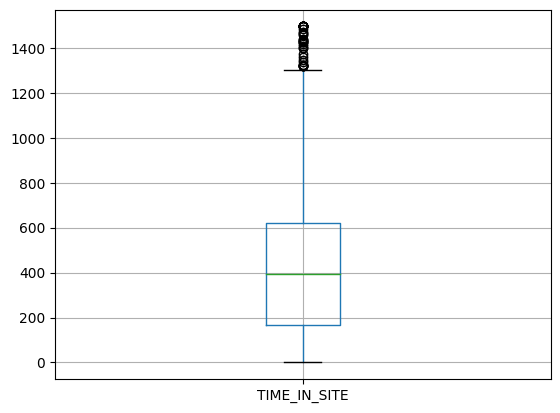

In [25]:
df_sub.boxplot(column=['TIME_IN_SITE'])

The distribution of TIME_IN_SITE is slightly left skewed, replace missing values with MEAN

In [26]:
mean_time_site = df_sub['TIME_IN_SITE'].mean()
df_sub['TIME_IN_SITE'] = df_sub['TIME_IN_SITE'].fillna(mean_time_site)


Replacing missing values in WAGE_SUBSIDY_ELIGIBLE with the proportion of existing values
### Part done MANUALLY in EXCEL -> filter on NULL values on WAGE_SUBSIDY_ELIGIBLE + rate_type (wage) + status (approved, etc.)


In [27]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].value_counts()

0.0    3853
1.0    1306
Name: WAGE_SUBSIDY_ELIGIBLE, dtype: int64

In [28]:
validRates = ['DES-DMS Wage Start Subsidy Payment', 'DES-DMS Wage Subsidy Fee', 'DES-ESS Wage Start Subsidy Payment', 'DES-ESS Wage Subsidy Fee', 'Restart Wage Subsidy DESA Payment', 'Restart Wage Subsidy DESB Payment', 'Restart Wage Subsidy DESB Payment', 'Restart Wage Subsidy Special Claim-DMS Job Seeker', 'Restart Wage Subsidy Special Claim-ESS Job Seeker']
validStatus = ['Approved', 'Pending', 'Lodged']



In [29]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].value_counts()

0.0    3853
1.0    1306
Name: WAGE_SUBSIDY_ELIGIBLE, dtype: int64

In [30]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'].isna().sum() #-> replace with 0 -> assuming the manual replacement in EXCEL has been done

0

In [31]:
df_sub['WAGE_SUBSIDY_ELIGIBLE'] = df_sub['WAGE_SUBSIDY_ELIGIBLE'].fillna(0)

In [32]:
# Cleaning the columns based on distinct values -->

df_sub['COUNTRY_OF_BIRTH'].isna().sum()
# 24 na's -> drop rows
df_sub = df_sub[df_sub['COUNTRY_OF_BIRTH'].notna()]


## INTERPRETER_LANGUAGE: if it is 'NOT APPLICABLE','NaN', 'Sign Language' -> then encode '0', otherwise '1'
no_inter = ['NOT APPLICABLE', 'NaN', 'Sign Language', '*', 'NULL']
df_sub['INTERPRETER_LANGUAGE'] = np.where(df_sub['INTERPRETER_LANGUAGE'].isin(no_inter), 0, 1)



# CULTURAL_linguist from 'COUNTRY_OF_BIRTH', 'INTERPRETER_LANGUAGE'
# if country_of_birth is NOT Australia, then 1 otherwise 0:
df_sub['COUNTRY_DIVERSE'] = np.where(df_sub['COUNTRY_OF_BIRTH'] != 'Australia', 1, 0)
df_sub['CULTURAL_LINGUIST'] = np.where((df_sub['COUNTRY_DIVERSE'] == 1) & (df_sub['INTERPRETER_LANGUAGE'] == 1), 1, 0)




## CURRENT_CAPACITY_HOURS: encode Aug-14 -> "8-14" range - but taking the midpoint  (and check with Depar why it would be Aug-14, should we use imputation?), remove NaN, remove UNKNOWN(count = 6)
# integer encoding with Midpoint (rounded down)

df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('Aug-14', '8-14')
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('NaN', 0)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('0-7', 3)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('8+', 8)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('8-14', 11)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('15-22', 18)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('23-29', 26)
df_sub['CURRENT_CAPACITY_HOURS'] = df_sub['CURRENT_CAPACITY_HOURS'].replace('30+', 30)
df_sub = df_sub[df_sub['CURRENT_CAPACITY_HOURS'] != 'UNNOWN']




## Gender: 0 for Male, 1 for Female
df_sub['GENDER'] = df_sub['GENDER'].replace('Female', 1)
df_sub['GENDER'] = df_sub['GENDER'].replace('Male', 0)


# Type conversions --
## INDIGENOUS_IND: Check that type is numeric 
## WAGE_SUBSIDY_ELIGIBLE: check type is numeric 

dict_types = {'INDIGENOUS_IND' : 'int', 'WAGE_SUBSIDY_ELIGIBLE' : 'int'}

df_sub = df_sub.astype(dict_types)

## MODERATE_INTELLECTUAL_DISABILITY - should include with 'DISABILITY_TYPE_CODE'? Or separately? - encode True, False with 0 and 1
df_sub['MODERATE_INTELLECTUAL_DISABILITY'] = np.where(df_sub['MODERATE_INTELLECTUAL_DISABILITY'] == False, 0, 1) 
# need to drop the 1
df_sub = df_sub[df_sub['MODERATE_INTELLECTUAL_DISABILITY'] != 1]



In [33]:
df_sub['INTERPRETER_LANGUAGE'].value_counts()

0    4548
1     604
Name: INTERPRETER_LANGUAGE, dtype: int64

In [34]:
df_sub['CURRENT_CAPACITY_HOURS'].value_counts()

18    2725
11    1878
26     194
3      191
8      123
30      36
Name: CURRENT_CAPACITY_HOURS, dtype: int64

In [35]:
df_sub[['RESIDENTIAL_ADDRESS_LINES', 'RESIDENTIAL_ADDRESS_SUBURB', 'RESIDENTIAL_ADDRESS_POSTCODE',
       'RESIDENTIAL_ADDRESS_STATE']]

,RESIDENTIAL_ADDRESS_LINES,RESIDENTIAL_ADDRESS_SUBURB,RESIDENTIAL_ADDRESS_POSTCODE,RESIDENTIAL_ADDRESS_STATE
0,8B EXETER RD,HOMEBUSH WEST,2140,NSW
1,34 CHURCHILL ST,FAIRFIELD,2165,NSW
2,U 16 6-10 OAKES ST,WESTMEAD,2145,NSW
3,15 ARGYLE PL,WEST PENNANT HILLS,2125,NSW
4,59 TRIBECA CCT,NORTH LAKES,4509,QLD
...,...,...,...,...
5154,21 SWIMMING POOL RD,TINGHA,2369,NSW
5155,5 HIDDEN VALLEY RD,BERRIMAH,828,NT
5156,57 REGENT ST,REGENTS PARK,2143,NSW
5157,188 SPRING ST,RESERVOIR,3073,VIC


Identifying the metro postcodes for each state
- Just using postcode and state
- Cleaning the columns

In [36]:
df_sub['RESIDENTIAL_ADDRESS_STATE'].value_counts()

NSW    2440
VIC    1360
QLD     934
SA      166
WA      111
TAS      82
NT       42
ACT      17
Name: RESIDENTIAL_ADDRESS_STATE, dtype: int64

In [37]:
# remove '*' in state
df_sub = df_sub[df_sub['RESIDENTIAL_ADDRESS_STATE'] != '*']
df_sub['RESIDENTIAL_ADDRESS_STATE'].value_counts()

# convert postcode to int
df_sub['RESIDENTIAL_ADDRESS_POSTCODE'] = df_sub['RESIDENTIAL_ADDRESS_POSTCODE'].astype('int64')

df_sub = df_sub[df_sub['GENDER'] != 'Unknown'] 

Metro postcodes for each state
source: https://support.shippit.com/hc/en-us/articles/4403703156377-Rule-to-Allocate-a-Courier-for-Metro-and-Regional-Destinations

Source: http://www.impactlists.com.au/ImpactLists/media/list-tools/Useful-Postcode-Ranges.pdf


In [38]:
### INDIGENOUS_STATUS and METRO LOCATION -> check address postcode AND state
df_sub['METRO'] = False # initialise the metro column to False values


# ind = 0 (start bounds), ind=1 (end bounds)
nsw_met = [[1000, 1920], [2000, 2239], [2555, 2574], [2740, 2786]] # sydney
qld_met = [[2484, 2494], [4000, 4370], [4373, 4381], [4400, 4405], [4500, 4580], [4600, 4610], [4614, 4618], [9000, 9919]] #brisbane
vic_met = [[3000, 3210], [3335, 3341], [3425, 3443], [3750, 3811], [3910, 3920], [3926, 3944], [3972, 3978], [3980, 3983], [8000, 8899]] #Melbourne
wa_met = [[6000, 6214], [6800, 6999]] #perth
tas_met = [[7000,7010], [7249,7250]] # hobart
sa_met = [[5000, 5199], [5800, 5999]] #adelaide
nt_met = [[800, 820], [900, 910]] # darwin
act_met = [[200,299], [2600, 2620], [2900,2920]] #canberra



# creating the "METRO" column - 1 if metro postcode, 0 otherwise
def metro_postcode(postcode_list, postcode):
    is_metro = False # initialise boolean 
    i = 0
    while i < len(postcode_list):
        start_bounds = int(postcode_list[i][0])
        end_bounds = int(postcode_list[i][1])
        if (postcode >= start_bounds) & ( postcode <= end_bounds):
            is_metro = True
            break
        i += 1

    return is_metro




# passing the postcodes to the 'metro_postcode' function ->
for i, row in df_sub.iterrows():
    x = df_sub['RESIDENTIAL_ADDRESS_POSTCODE'][i] #postcode
    if x is None:
        pass 
    else: 
        # getting the state
        state = df_sub['RESIDENTIAL_ADDRESS_STATE'][i]
        if state == 'NSW':
            df_sub['METRO'][i] = metro_postcode(nsw_met, x)
        elif state == 'QLD':
            df_sub['METRO'][i] = metro_postcode(qld_met, x)
        elif state == 'VIC':
            df_sub['METRO'][i] = metro_postcode(vic_met, x)
        elif state == 'WA':
            df_sub['METRO'][i] = metro_postcode(wa_met, x)
        elif state == 'TAS':
            df_sub['METRO'][i] = metro_postcode(tas_met, x)
        elif state == 'SA':
            df_sub['METRO'][i] = metro_postcode(sa_met, x)
        elif state == 'NT':
            df_sub['METRO'][i] = metro_postcode(nt_met, x)
        elif state == 'ACT':
            df_sub['METRO'][i] = metro_postcode(act_met, x)
        else: 
            pass



In [39]:
df_sub[["RESIDENTIAL_ADDRESS_POSTCODE", "RESIDENTIAL_ADDRESS_STATE", "METRO"]].head(5)
# encode True -> 1, False -> 0
df_sub["METRO"] = np.where(df_sub["METRO"] == True, 1, 0)

# filtering for INDIGENOUS_INDICATOR = 1 and METRO = 1
df_sub['IND_METRO'] = np.where((df_sub['INDIGENOUS_IND'] == 1) & (df_sub['METRO'] == 1), 1, 0) 

df_sub[["RESIDENTIAL_ADDRESS_POSTCODE", "RESIDENTIAL_ADDRESS_STATE", "METRO", "INDIGENOUS_IND", "IND_METRO"]].head(10)

,RESIDENTIAL_ADDRESS_POSTCODE,RESIDENTIAL_ADDRESS_STATE,METRO,INDIGENOUS_IND,IND_METRO
0,2140,NSW,1,0,0
1,2165,NSW,1,0,0
2,2145,NSW,1,0,0
3,2125,NSW,1,0,0
4,4509,QLD,1,0,0
5,4066,QLD,1,0,0
6,6125,WA,1,0,0
7,2452,NSW,0,0,0
8,3199,VIC,1,0,0
9,2325,NSW,0,0,0


In [40]:
# Checking missing values again: 
naVal = df_sub.isna().sum() * 100 / len(df)
missValDf = pd.DataFrame({'column_name' : df_sub.columns, 'percent_missing' : naVal})
missValDf.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
INTERPRETER_LANGUAGE_CODE,INTERPRETER_LANGUAGE_CODE,88.137236
RATE_TYPE,RATE_TYPE,19.771274
STATUS,STATUS,19.771274
CURRENT_CAPACITY_HOURS,CURRENT_CAPACITY_HOURS,0.096918
METRO,METRO,0.000000
CULTURAL_LINGUIST,CULTURAL_LINGUIST,0.000000
COUNTRY_DIVERSE,COUNTRY_DIVERSE,0.000000
AGE,AGE,0.000000
DISABILITY_TYPE,DISABILITY_TYPE,0.000000
MODERATE_INTELLECTUAL_DISABILITY,MODERATE_INTELLECTUAL_DISABILITY,0.000000


In [41]:
# dropping the current_capacity_hours missing values
df_sub = df_sub[df_sub['CURRENT_CAPACITY_HOURS'].isna() == False]

In [42]:
naVal = df_sub.isna().sum() * 100 / len(df)
missValDf = pd.DataFrame({'column_name' : df_sub.columns, 'percent_missing' : naVal})
missValDf.sort_values(by=['percent_missing'], ascending=False)

,column_name,percent_missing
INTERPRETER_LANGUAGE_CODE,INTERPRETER_LANGUAGE_CODE,88.040318
RATE_TYPE,RATE_TYPE,19.771274
STATUS,STATUS,19.771274
METRO,METRO,0.000000
CULTURAL_LINGUIST,CULTURAL_LINGUIST,0.000000
COUNTRY_DIVERSE,COUNTRY_DIVERSE,0.000000
AGE,AGE,0.000000
DISABILITY_TYPE,DISABILITY_TYPE,0.000000
MODERATE_INTELLECTUAL_DISABILITY,MODERATE_INTELLECTUAL_DISABILITY,0.000000
TIME_IN_PROVIDER,TIME_IN_PROVIDER,0.000000


### Final variables subset for logistic regression model

In [43]:
features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']


# Identifying strong predictors for numerating participants

Using StandardScalar to standardise the data

In [44]:
#PCA
features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']


### Correlation Matrix
Between numeric variables

In [45]:
df_sub.dtypes

DATE_OF_BIRTH                        object
COUNTRY_OF_BIRTH                     object
CURRENT_CAPACITY_HOURS               object
JOB_SEEKER_ID                       float64
GENDER                               object
INTERPRETER_LANGUAGE                  int32
INTERPRETER_LANGUAGE_CODE            object
RESIDENTIAL_ADDRESS_LINES            object
RESIDENTIAL_ADDRESS_SUBURB           object
RESIDENTIAL_ADDRESS_STATE            object
RESIDENTIAL_ADDRESS_POSTCODE          int64
INDIGENOUS_IND                        int32
WAGE_SUBSIDY_ELIGIBLE                 int32
RATE_TYPE                            object
STATUS                               object
TIME_IN_STREAM                      float64
TIME_IN_PROGRAM                     float64
TIME_IN_SITE                        float64
TIME_IN_PROVIDER                    float64
MODERATE_INTELLECTUAL_DISABILITY      int32
DISABILITY_TYPE                       int32
AGE                                   int64
COUNTRY_DIVERSE                 

Checking whether there exists variable with all 0s or 1s -> to avoid PerfectSeparation error in the logistic regression

In [46]:
#for col in df_sub:
#    print(col , df_sub[col].unique())

In [47]:
df_feat = df_sub[['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'MODERATE_INTELLECTUAL_DISABILITY', 'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']]
df_feat.corr()

,INDIGENOUS_IND,WAGE_SUBSIDY_ELIGIBLE,TIME_IN_STREAM,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,MODERATE_INTELLECTUAL_DISABILITY,AGE,COUNTRY_DIVERSE,CULTURAL_LINGUIST,IND_METRO
INDIGENOUS_IND,1.000000,0.008858,-0.004152,-0.006812,-0.013028,-0.019892,NaN,-0.079387,-0.175981,-0.092390,0.671052
WAGE_SUBSIDY_ELIGIBLE,0.008858,1.000000,0.544276,0.547625,0.291740,0.326341,NaN,-0.372739,-0.139713,-0.113978,0.014959
TIME_IN_STREAM,-0.004152,0.544276,1.000000,0.987055,0.526164,0.582591,NaN,-0.113543,-0.040019,-0.038504,-0.011219
TIME_IN_PROGRAM,-0.006812,0.547625,0.987055,1.000000,0.532082,0.587696,NaN,-0.114235,-0.039647,-0.033942,-0.014252
TIME_IN_SITE,-0.013028,0.291740,0.526164,0.532082,1.000000,0.844221,NaN,0.072502,0.016885,-0.008383,-0.000129
TIME_IN_PROVIDER,-0.019892,0.326341,0.582591,0.587696,0.844221,1.000000,NaN,0.064625,0.019743,0.003665,0.001864
MODERATE_INTELLECTUAL_DISABILITY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGE,-0.079387,-0.372739,-0.113543,-0.114235,0.072502,0.064625,NaN,1.000000,0.319490,0.220940,-0.053991
COUNTRY_DIVERSE,-0.175981,-0.139713,-0.040019,-0.039647,0.016885,0.019743,NaN,0.319490,1.000000,0.523948,-0.116634
CULTURAL_LINGUIST,-0.092390,-0.113978,-0.038504,-0.033942,-0.008383,0.003665,NaN,0.220940,0.523948,1.000000,-0.063660


Dropping the NaN correlation variables

In [48]:
df_feat =  df_sub[['CURRENT_CAPACITY_HOURS', 'GENDER', 'DISABILITY_TYPE', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']]

corr_matrix = df_feat.corr()
corr_matrix.style.background_gradient(cmap='Blues')

,DISABILITY_TYPE,INDIGENOUS_IND,WAGE_SUBSIDY_ELIGIBLE,TIME_IN_STREAM,TIME_IN_PROGRAM,TIME_IN_SITE,TIME_IN_PROVIDER,AGE,COUNTRY_DIVERSE,CULTURAL_LINGUIST,IND_METRO
DISABILITY_TYPE,1.000000,-0.056922,-0.164610,-0.058711,-0.061422,0.050008,0.037291,0.391028,0.231328,0.205378,-0.049200
INDIGENOUS_IND,-0.056922,1.000000,0.008858,-0.004152,-0.006812,-0.013028,-0.019892,-0.079387,-0.175981,-0.092390,0.671052
WAGE_SUBSIDY_ELIGIBLE,-0.164610,0.008858,1.000000,0.544276,0.547625,0.291740,0.326341,-0.372739,-0.139713,-0.113978,0.014959
TIME_IN_STREAM,-0.058711,-0.004152,0.544276,1.000000,0.987055,0.526164,0.582591,-0.113543,-0.040019,-0.038504,-0.011219
TIME_IN_PROGRAM,-0.061422,-0.006812,0.547625,0.987055,1.000000,0.532082,0.587696,-0.114235,-0.039647,-0.033942,-0.014252
TIME_IN_SITE,0.050008,-0.013028,0.291740,0.526164,0.532082,1.000000,0.844221,0.072502,0.016885,-0.008383,-0.000129
TIME_IN_PROVIDER,0.037291,-0.019892,0.326341,0.582591,0.587696,0.844221,1.000000,0.064625,0.019743,0.003665,0.001864
AGE,0.391028,-0.079387,-0.372739,-0.113543,-0.114235,0.072502,0.064625,1.000000,0.319490,0.220940,-0.053991
COUNTRY_DIVERSE,0.231328,-0.175981,-0.139713,-0.040019,-0.039647,0.016885,0.019743,0.319490,1.000000,0.523948,-0.116634
CULTURAL_LINGUIST,0.205378,-0.092390,-0.113978,-0.038504,-0.033942,-0.008383,0.003665,0.220940,0.523948,1.000000,-0.063660


### Relationships between Features Chart

In [49]:
import seaborn as sns
df_feat_num =  df_sub[['CURRENT_CAPACITY_HOURS', 'GENDER', 'DISABILITY_TYPE', 'INDIGENOUS_IND', 'WAGE_SUBSIDY_ELIGIBLE', 'TIME_IN_STREAM', 'TIME_IN_PROGRAM', 'TIME_IN_SITE', 'TIME_IN_PROVIDER',
       'AGE', 'COUNTRY_DIVERSE', 'CULTURAL_LINGUIST', 'IND_METRO']]
sns.pairplot(data = df_feat_num, diag_kind='kde')
plt.show()

### Reasons for Low Accuracy in Model (13 week outcomes)
from analysis of sns pairplot:

- Across the diagonal where each feature is plotted against itself, the distribution of each feature differs.  
- IND_METRO: no strong relations to Num_13. When indicator is 0 and 1, Num_13 = 0, and left skewed 
- CULTURAL_LINGUIST: no strong relation, and left skewed
- COUNTRY_DIVERSE: no strong relation 
- None of the variables are strong indicators for Num_13. 
However, we can reduce correlation between the variables and reduce dimensionality. 
Note: Since Num_13 is imbalanced with Num_13 = 1 as the majority class -> then there may be a slight right-hand skew against the features 

- TIME_IN_PROGRAM and TIME_IN_STREAM -> positive correlation (REMOVE ONE)
- TIME_IN_SITE and TIME_IN_PROVIDER -> positive correlation (REMOVE ONE)
- AGE is right skewed
- Two peaks (0, 1) with binary features 
- WAGE_SUBSIDY_ELIGIBLE -> left skewed
- INDIGEOUS_IND -> left skewed

Subsetting the features and reducing dependency between these. Final subset: 

features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'INDIGENOUS_IND', 'DISABILITY_TYPE', 'TIME_IN_PROGRAM', 'TIME_IN_SITE',
       'AGE']

### Checking class imbalance 

#### Solution: Upsampling the minority class (1) with replacement

### Binary Logistic Regression Model (Num_13 = 0 or 1)
Dependent var: 0 or 1 (Num_13)
Independent: features

In [ ]:
features = ['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO', 'CULTURAL_LINGUIST']


Across Diagonal -> correct predictions for Binary output (0, 1)


In [ ]:
from sklearn.metrics import classification_report


- f1-score (comb. of precision and recall is 0.81 for both classes)
- support = no. of actual occurrences of the class in the specified dataset

Coefficients for the Model

### Final LG equation - for a person to record an outcome (Num_13 = 1):

logit(p) = -0.154(AGE_AT_EXTRACT) - 1.394(WEEKS_REGISTERED) - 1.184(TEMP_CAPACITY_2_HOURS) + 0.375(CURRENT_CAPACITY_HOURS) - 0.446(FUTURE_CAPACITY_INTERVENTION_HOURS) -0.359(JSCI_PERSONAL_FACTORS_OUTCOME) - 1.536(CALD) - 0.348



### Stat Regression Function (13, 26, 52 week)

### Improve performance - GridSearch for hyperparameter tuning for Logistic Regression model 

### Passing each job seeker row -> eval regression function

In [ ]:
df_13['Num_13'].value_counts()


0    2702
1    2268
Name: Num_13, dtype: int64

In [ ]:
x = 233/1030
x # defines the ratio of class weights
1 - x

0.7737864077669903

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report


def eval_regression(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj:
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    

    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16, stratify=y)
    # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    
    smote = SMOTE(sampling_strategy=1, random_state=12)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
  
    # creating a balanced training dataset ->
    X_train = StandardScaler().fit_transform(X_resampled)
    X_test = StandardScaler().fit_transform(X_test)
    
    
    ## HYPERPARAMETER TUNING with GridSearchCV ------------------------
    params = {'C':[0.01, 0.1, 1, 10, 100]}

    clf = LogisticRegression(penalty='l2', random_state=42)

    folds = 5
    model_cv = GridSearchCV(estimator = clf, 
                            param_grid = params, 
                            scoring= 'accuracy', 
                            cv = folds,
                            return_train_score=True,
                            verbose = 3)

    model_cv.fit(X_resampled, y_resampled) # fit on training
    # getting the best hyper-parameter
    C = model_cv.best_params_
    hyperVal = C.get('C')



    # define model 
    logreg = LogisticRegression(C=hyperVal, penalty='l2', random_state=42)



    # fit the model
    model = logreg.fit(X_resampled, y_resampled) # trained set

    y_pred = model.predict(X_test)

    print(y_pred)

    # confusion matrix:
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

    #printing test set results
    class_report = classification_report(y_test, y_pred)

    # print the AUC:
    y_pred_proba = logreg.predict_proba(X_train)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_resampled,  y_pred_proba)
    auc = metrics.roc_auc_score(y_resampled, y_pred_proba)
    ### AUC - COMMENTED OUT
    #plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    #plt.legend(loc=4)
    #plt.show()
    

    # the logistic regression equation 
    
    coef = model.coef_
    coef = list(coef)
    intercept = model.intercept_
    df_merge = df_merge[['JOB_SEEKER_ID','CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']]
    type_dict = {'CURRENT_CAPACITY_HOURS' : float, 'GENDER' : float, 'TIME_IN_SITE' : float, 'DISABILITY_TYPE' : float, 'AGE' : float, 'INDIGENOUS_IND' : float, 'IND_METRO' : float}
    df_merge = df_merge.astype(type_dict)
    return cnf_matrix, class_report, coef, intercept, df_merge, model

In [ ]:
print(features)

['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']


In [ ]:
df_13

,Unnamed: 0,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code
0,0,9386301003,0,1.0,AimBig Employment WOY WOY,0212812K,AALL
1,0,8653691003,0,1.0,AimBig Employment FAIRFIELD,0212899A,AALL
2,0,7870290004,0,1.0,AimBig Employment NORTH LAKES,0212795D,AALL
3,0,6498977509,1,1.0,AimBig Employment LEICHHARDT,0212845J,AALL
4,0,6638331004,0,1.0,AimBig Employment NORTH LAKES,0212795D,AALL
...,...,...,...,...,...,...,...
4965,0,2836891309,1,1.0,AimBig Employment CORIO,0212862K,AALL
4966,0,8771045004,0,1.0,AimBig Employment FRANKSTON,0212818F,MENH
4967,0,15325790,1,1.0,AimBig Employment MACKAY,0212803K,MUSK
4968,0,690092007,1,1.0,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL


### 13, 26, 52 week stat regression outcomes

1. Model coefficients would differ based on each performance measure
2. Generate the model coefficients, get from the eval_regression function. Create a formula.
3. Pass each performance measure dataframe (df_n) 

### 13 week outcomes to regression function
- Using model_13 -> pass each row of the dataframe to the model and call "model.pred(row)" -> set this to expected 

In [ ]:
cnf_matrix_13, class_report_13, coef_13, intercept_13, df_merge_13, model_13 = eval_regression(df_13, df_sub, features, 'Num_13')



NameError: name 'df_13' is not defined

In [ ]:
print(class_report_13)

              precision    recall  f1-score   support

           0       0.41      0.51      0.45       203
           1       0.62      0.52      0.56       307

    accuracy                           0.52       510
   macro avg       0.51      0.51      0.51       510
weighted avg       0.53      0.52      0.52       510



### KNN 

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline
def knn_regression(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj:
    
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    df_merge['JOB_SEEKER_ID'] = df_merge['JOB_SEEKER_ID'].astype('int64')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    # target (Num_13)
    y = df_sub[num_n]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=16)
    rus = RandomOverSampler(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train) # only resample after train/test split
    # creating a balanced training dataset -> # scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    X_train = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)
    X_resampled = X_train  
    

    # define model 
    knn_model = KNeighborsClassifier(n_neighbors=6, metric='minkowski', p=2)

    # fit the model
    model = knn_model.fit(X_resampled, y_resampled) # trained set

    y_pred = model.predict(X_test)

    print(y_pred)

    rmse_val = []
    ### Model Inspection 
    for K in range(20):
        K = K+1
        model = neighbors.KNeighborsClassifier(n_neighbors=K)
        model.fit(X_resampled, y_resampled) # fit on x and y train
        pred = model.predict(X_test)
        error = sqrt(mean_squared_error(y_test, pred))
        rmse_val.append(error)
        print('RMSE value for k= ' , K , 'is:', error)
    
    # plot curve
    curve = pd.DataFrame(rmse_val)
    curve.plot()

   
    # print classification report
    print(accuracy_score(y_test, y_pred))

    # print confusion matrix
    print(confusion_matrix(y_test, y_pred))
    
    return model, X_train, X_test, y_resampled, y_test

[0 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0
 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1
 0 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0
 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1
 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1
 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1
 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0
 0 1 1 1 0 1 0 0 1 0 0 0 

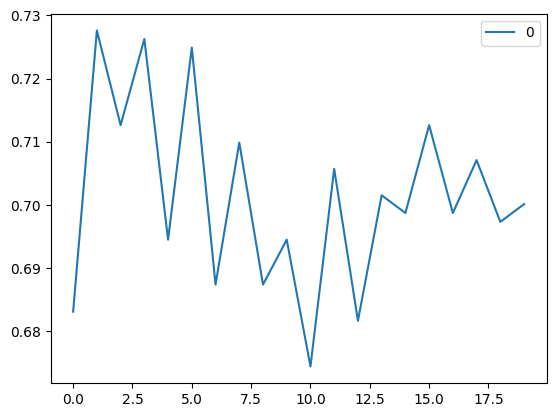

In [ ]:
model_13, X_train, X_test, y_resampled, y_test = knn_regression(df_13, df_sub, features, 'Num_13')

#### Finding the appropriate values for k 
Through exploration of the elbow graph, the ideal number of neighbours with the lowest RMSE is ~8. Neighbours at 15 generates a lower accuracy.

### Generating expected outcomes for 13 week 
- Addition of a 'Num_13_exp' -> Numerator for 13 week EXPECTED column in the "df_13" one
- Using model_13 -> pass each row of the dataframe to the model and call "model.pred(row)" -> set this to expected 
- Passing all rows (1263) of df_13 t

In [ ]:
model_13

KNeighborsClassifier(n_neighbors=20)

In [ ]:
# set df_13['JOB_SEEKER_ID'] as the index
df_13 = df_13.set_index('JOB_SEEKER_ID')
# create Num_13_exp column
df_13['Num_13_exp'] = 0

In [ ]:
df_13 = df_13.drop(columns={'Unnamed: 0'})

In [ ]:
df_13.value_counts()

Num_13  Den_13  Site_Name                        Contract_ID  specialist_site_type_code  Num_13_exp
1       1.0     AimBig Employment CABRAMATTA     0212844H     AALL                       0             62
0       1.0     AimBig Employment MOONEE PONDS   0212886G     AALL                       0             62
                AimBig Employment CABRAMATTA     0212844H     AALL                       0             56
                AimBig Employment MOONEE PONDS   0212817E     AALL                       0             48
                AimBig Employment TOOWONG        0212879H     AALL                       0             48
                                                                                                       ..
1       1.0     AimBig Employment SOUTHPORT      0212794C     (blank)                    0              1
0       1.0     AimBig Employment DEVONPORT      0212869F     MUSK                       0              1
1       1.0     AimBig Employment DARWIN CITY    021

In [ ]:
df_merge_13

,JOB_SEEKER_ID,CURRENT_CAPACITY_HOURS,GENDER,TIME_IN_SITE,DISABILITY_TYPE,AGE,INDIGENOUS_IND,IND_METRO
0,168470,11.0,1.0,800.0,1.0,22.0,0.0,0.0
1,3091044909,8.0,0.0,530.0,1.0,26.0,0.0,0.0
2,9690339309,11.0,1.0,1009.0,1.0,51.0,0.0,0.0
3,2641013609,18.0,1.0,106.0,1.0,37.0,0.0,0.0
4,3549240,18.0,1.0,1223.0,0.0,37.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1693,2878234003,18.0,0.0,581.0,1.0,54.0,0.0,0.0
1694,8332235003,18.0,1.0,530.0,1.0,44.0,0.0,0.0
1695,8562966409,3.0,0.0,552.0,1.0,55.0,0.0,0.0
1696,19457490,18.0,1.0,434.0,1.0,19.0,0.0,0.0


In [ ]:
# merge df_13 with df_merge_13
df_13_final = df_merge_13.merge(df_13, on=['JOB_SEEKER_ID'], how='inner')
df_13_final = df_13_final.rename(columns={'Num_13' : 'Num_13_full', 'Den_13' : 'Den_13_full'})

In [ ]:
df_13_final = df_13_final[["JOB_SEEKER_ID", "Num_13_full", "Den_13_full"]]
df_13 = df_13_final
df_13['Num_13_exp'] = 0 #initilalise expected outcomes

In [ ]:
print(features)

['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']


Given the class imbalance -> resample, when predicting, to offset the prediction of all 0s

In [ ]:
# passing each dataframe row of df_merge_13 to the model.pred()
for index, row in df_merge_13.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']])
    X_test = X_test.values.reshape(1, -1)
   
    df_13.loc[index].Num_13_exp = model_13.predict(X_test)
    

#### Output file for 13 week expected outcomes

In [ ]:
df_13.to_csv('df_13_exp.csv')

df_13['Num_13_exp'].value_counts()

0    1698
Name: Num_13_exp, dtype: int64

Merging df_n with df_merge_n - to get common rows

### Passing the 26 week outcome to the stat_regression function 
- Creating 3 subset dataframes for 3 performance subtypes: Full, Pathway, Work Assist/Bonus\
- Removing NaN values

In [ ]:
# 26 week outcome
df_26 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_26_new.csv")
df_26_full = df_26[["Job_Seeker_ID", "Num_26_full", "Den_26_full"]]
df_26_full = df_26_full.dropna()
df_26_path = df_26[["Job_Seeker_ID", "Num_26_path", "Den_26_path"]]
df_26_path = df_26_path.dropna()
df_26_wrkast = df_26[["Job_Seeker_ID", "Num_26_wrkast", "Den_26_wrkast"]]
df_26_wrkast = df_26_wrkast.dropna()

In [ ]:
df_26


,Unnamed: 0,Job_Seeker_ID,Num_26,Den_26,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast
0,0,9386301003,NaN,NaN,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
1,0,8653691003,NaN,NaN,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,1.0,0.0,1.0,0.0,0.0
2,0,7870290004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,1.0,0.0,1.0,0.0,0.0
3,0,6498977509,NaN,NaN,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0,0.0,0.0
4,0,6638331004,NaN,NaN,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,0,2836891309,NaN,NaN,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
4966,0,8771045004,NaN,NaN,AimBig Employment FRANKSTON,0212818F,MENH,0.0,1.0,0.0,1.0,0.0,0.0
4967,0,15325790,NaN,NaN,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0,0.0,0.0
4968,0,690092007,NaN,NaN,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_26_full['Num_26_full'].value_counts()

0.0    3248
1.0    1722
Name: Num_26_full, dtype: int64

In [ ]:
df_26_path['Num_26_path'].value_counts()

0.0    4921
1.0      49
Name: Num_26_path, dtype: int64

In [ ]:
df_26_wrkast['Num_26_wrkast'].value_counts()

0.0    4970
Name: Num_26_wrkast, dtype: int64

In [ ]:
cnf_matrix_26, class_report_26, coef_26, intercept_26, df_merge_26, model_26 = eval_regression(df_26_full, df_sub, features, 'Num_26_full')


print("26 week FULL outcome" + '\n')
print(cnf_matrix_26)
print(class_report_26)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........C=0.01;, score=(train=0.557, test=0.534) total time=   0.0s
[CV 2/5] END ........C=0.01;, score=(train=0.543, test=0.502) total time=   0.0s
[CV 3/5] END ........C=0.01;, score=(train=0.529, test=0.536) total time=   0.0s
[CV 4/5] END ........C=0.01;, score=(train=0.545, test=0.532) total time=   0.0s
[CV 5/5] END ........C=0.01;, score=(train=0.535, test=0.532) total time=   0.0s
[CV 1/5] END .........C=0.1;, score=(train=0.553, test=0.557) total time=   0.0s
[CV 2/5] END .........C=0.1;, score=(train=0.574, test=0.488) total time=   0.0s
[CV 3/5] END .........C=0.1;, score=(train=0.542, test=0.573) total time=   0.0s
[CV 4/5] END .........C=0.1;, score=(train=0.555, test=0.542) total time=   0.0s
[CV 5/5] END .........C=0.1;, score=(train=0.538, test=0.553) total time=   0.0s
[CV 1/5] END ...........C=1;, score=(train=0.551, test=0.557) total time=   0.0s
[CV 2/5] END ...........C=1;, score=(train=0.571,

### Since there is only one class for 26 week work assist/pathway - use the model for the full outcome for prediction



##### 26 week full outcome (expected)

In [ ]:
df_26_full = df_26_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_26
df_26_full_m = df_merge_26.merge(df_26_full, on=['JOB_SEEKER_ID'], how='inner')

df_merge_26 = df_26_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_26 = df_merge_26.set_index('JOB_SEEKER_ID')

In [ ]:
df_26_full_m
df_26_full = df_26_full_m[["JOB_SEEKER_ID", "Num_26_full", "Den_26_full"]]
df_26_full['Num_26_full_exp'] = 0
df_26_full = df_26_full.set_index('JOB_SEEKER_ID')

In [ ]:
for index, row in df_merge_26.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']])
    X_test = X_test.values.reshape(1, -1)
    if index == 0:
        pass
    else:
        df_26_full.loc[index].Num_26_full_exp = model_26.predict(X_test)
    

##### 26 week pathway outcome (expected)

In [ ]:
df_26_path = df_26_path.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_26
df_26_path_m = df_merge_26.merge(df_26_path, on=['JOB_SEEKER_ID'], how='inner')

df_merge_26 = df_26_path_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_26 = df_merge_26.set_index('JOB_SEEKER_ID')

In [ ]:
df_26_path_m
df_26_path = df_26_path_m[["JOB_SEEKER_ID", "Num_26_path", "Den_26_path"]]
df_26_path['Num_26_path_exp'] = 0
df_26_path = df_26_path.set_index('JOB_SEEKER_ID')

In [ ]:
for index, row in df_merge_26.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']])
    X_test = X_test.values.reshape(1, -1)
    if index == 0:
        pass
    else:
        df_26_path.loc[index].Num_26_path_exp = model_26.predict(X_test)
    

#### 26 week work assist/bonus outcome (expected)

In [ ]:
df_26_wrkast = df_26_wrkast.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_26
df_26_wrkast_m = df_merge_26.merge(df_26_wrkast, on=['JOB_SEEKER_ID'], how='inner')

df_merge_26 = df_26_wrkast_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_26 = df_merge_26.set_index('JOB_SEEKER_ID')

In [ ]:
df_26_wrkast_m
df_26_wrkast = df_26_wrkast_m[["JOB_SEEKER_ID", "Num_26_wrkast", "Den_26_wrkast"]]
df_26_wrkast['Num_26_wrkast_exp'] = 0
df_26_wrkast = df_26_wrkast.set_index('JOB_SEEKER_ID')

In [ ]:
for index, row in df_merge_26.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']])
    X_test = X_test.values.reshape(1, -1)
    if index == 0:
        pass
    else:
        df_26_wrkast.loc[index].Num_26_wrkast_exp = model_26.predict(X_test)


In [ ]:
df_26.value_counts

<bound method DataFrame.value_counts of       Unnamed: 0  Job_Seeker_ID  Num_26  Den_26  \
0              0     9386301003     NaN     NaN   
1              0     8653691003     NaN     NaN   
2              0     7870290004     NaN     NaN   
3              0     6498977509     NaN     NaN   
4              0     6638331004     NaN     NaN   
...          ...            ...     ...     ...   
4965           0     2836891309     NaN     NaN   
4966           0     8771045004     NaN     NaN   
4967           0       15325790     NaN     NaN   
4968           0      690092007     NaN     NaN   
4969           0        5766520     NaN     NaN   

                              Site_Name Contract_ID specialist_site_type_code  \
0             AimBig Employment WOY WOY    0212812K                      AALL   
1           AimBig Employment FAIRFIELD    0212899A                      AALL   
2         AimBig Employment NORTH LAKES    0212795D                      AALL   
3          AimBig Emplo

### Passing 52 performance measure to regression function
- Since only 1 class in 52 week outcome -> using the 26 week prediction function 
- Replace line 9 when more data comes in.

##### 52 week full outcome (expected)

In [ ]:
df_52 = pd.read_csv("C:/Users/AManalo/star_ratings_new/df_52_new.csv")
df_52_full = df_52[["Job_Seeker_ID", "Num_52_full", "Den_52_full"]]

df_52_path = df_52[["Job_Seeker_ID", "Num_52_path", "Den_52_path"]]


df_52_full = df_52_full.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_52
df_52_full_m = df_sub.merge(df_52_full, on=['JOB_SEEKER_ID'], how='inner')

df_merge_52 = df_52_full_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_52 = df_merge_52.set_index('JOB_SEEKER_ID')

In [ ]:
df_52_full_m
df_52_full = df_52_full_m[["JOB_SEEKER_ID", "Num_52_full", "Den_52_full"]]
df_52_full['Num_52_full_exp'] = 0
df_52_full = df_52_full.set_index('JOB_SEEKER_ID')

In [ ]:
for index, row in df_merge_52.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']])
    X_test = X_test.values.reshape(1, -1)
    if index == 0:
        pass
    else:
        df_52_full.loc[index].Num_52_full_exp = model_26.predict(X_test)

##### 52 week pathway outcome (expected)
- Using df_sub instead of df_merge_26 - as this restricts it to 26 week job seekers

In [ ]:
df_52_path = df_52_path.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
# merge with df_merge_52
df_52_path_m = df_sub.merge(df_52_path, on=['JOB_SEEKER_ID'], how='inner')

df_merge_52 = df_52_path_m[["JOB_SEEKER_ID", "CURRENT_CAPACITY_HOURS", "GENDER", "TIME_IN_SITE", "DISABILITY_TYPE", "AGE", "INDIGENOUS_IND", "IND_METRO"]]

df_merge_52 = df_merge_52.set_index('JOB_SEEKER_ID')



In [ ]:
df_52_path_m
df_52_path = df_52_path_m[["JOB_SEEKER_ID", "Num_52_path", "Den_52_path"]]
df_52_path['Num_52_path_exp'] = 0
df_52_path = df_52_path.set_index('JOB_SEEKER_ID')

    Empty -> because df_merge is based on df_merge_26 outcome

In [ ]:
for index, row in df_merge_52.iterrows():
    X_test = pd.Series(row[['CURRENT_CAPACITY_HOURS', 'GENDER', 'TIME_IN_SITE', 'DISABILITY_TYPE', 'AGE', 'INDIGENOUS_IND', 'IND_METRO']])
    X_test = X_test.values.reshape(1, -1)
    if index == 0:
        pass
    else:
        df_52_path.loc[index].Num_52_path_exp = model_26.predict(X_test)

In [ ]:
# cnf_matrix_52, class_report_52, coef, intercept = eval_regression(df_52_full, df_sub, features, 'Num_52_full')


# print("52 FULL week outcome" + '\n')
# print(cnf_matrix_52)
# print(class_report_52)




In [ ]:
# cnf_matrix_52, class_report_52 = eval_regression(df_52_path, df_sub, features, 'Num_52_path')


# print("52 PATH week outcome" + '\n')
# print(cnf_matrix_52)
# print(class_report_52)

### Random Forest for regression - To-Do

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
def eval_regression(df_n, df_apj, features, n_type):
    '''Evaluation of the statistical regression fuction. Passes each performance measure dataframe (from pre-quarterisation) and predicts whether a participant numerates based on
    demographic variables. Returns the classification metric report, confusion matrix and the logreg equation. Input: takes df_n (df_13, df_26, or df_52), and df_apj (stream_participant and jobseeker), 'n' : string of the performance measure,
    df_upsampled: dataframe for the upsampled minority class of df_n (if class imbalance - otherwise None).
    df_apj is the equivalent to the df_sub that has been pre-processed prior and outside of the function'''
    df_n = df_n.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
    df_n['JOB_SEEKER_ID'] = df_n['JOB_SEEKER_ID'].astype('int64')
    # merging df_n and df_apj:
    df_merge = df_apj.merge(df_n, on=['JOB_SEEKER_ID'], how='inner')
    # check class imbalance:
    df_sub = df_merge
    num_n = str(n_type)
   
    
    

    # running the Binary Logistic Regression (Num_n = 0, or Num_n = 1)
    #separation of the features:
    x = df_sub.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    # target (Num_13)
    y = df_sub[num_n]
    
    # creating a balanced training dataset ->
    ros = RandomOverSampler(random_state=16)
    X_resampled, y_resampled = ros.fit_resample(x, y) # only resample after train/test split
    


    #regressor object
    regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
    regressor.fit(X_resampled, y_resampled)
    
    return

### Expected Performance using Stat Regression Model
- No. of participants (NOT the no. of times they denominate) in the DEN post-quarterisation per performance measure 
- Expected = no. of outcomes (participants in the numerator)
- Per contract per performance measure 


Method: 
1. Group data by jobseeker -> site -> contract 
- Bring in an additional dataframe that contains site/contract info.
- Merge using job_seeker_id to df_merge
- Aggregate into a groupBy object
2. Create a separate test set without labels ('1') for numerator 


#### Aggregating into a groupBy object
- by site -> contract


In [ ]:
# reading in the site/contract dataframe 
df_scg  = pd.read_csv("C:/Users/AManalo/star_ratings_new/site_contract_groups.csv")
print(len(df_scg))
df_scg.dtypes

# pre-processing the dataframe
df_scg.isna().sum()

16996


Program                          0
ess_identifier                   0
Contract ID                    220
Site Code                      126
Site Description               126
ESA Code                         0
ESA Name                       126
State                          126
specialist_site_type_code    11683
dtype: int64

In [ ]:
# renaming the columns
df_scg = df_scg.rename(columns={'ESA Code' : 'esa_code'})

1. Site Code
2. Site Description 
can both be null -> as these both generate unique rows in the government released star ratings file. For the sake of data type conversion -> Empty values are encoded as 'XXXX' 

NOT NULL - defines each group (keys of the group)
1. Contract ID
2. ESA Code
3. Speciality_site_type_code


In [ ]:
df_scg[df_scg['Contract ID'] == '0212822B'].to_csv('missing_test.csv')

In [ ]:
df_scg = df_scg[df_scg['Contract ID'].isna() == False]
df_scg = df_scg[df_scg['esa_code'].isna() == False]
df_scg = df_scg[df_scg['specialist_site_type_code'].isna() == False]

In [ ]:
df_scg['Site Code'] = df_scg['Site Code'].fillna(value='XXXX')
df_scg

,Program,ess_identifier,Contract ID,Site Code,Site Description,esa_code,ESA Name,State,specialist_site_type_code
14,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL
18,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK
20,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH
21,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK
24,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH
...,...,...,...,...,...,...,...,...,...
16991,DMS,2730016019,0212841E,Y947,AimBig Employment MERRYLANDS,4CWS,Northern Sydney,NSW,AALL
16992,DMS,2696040,0212857B,ML77,AimBig Employment WOLLONGONG,4WOL,South East Sydney,NSW,MUSK
16993,DMS,5892574007,0212825E,MM77,AimBig Employment MELBOURNE,4YAR,Northern Victoria,VIC,MUSK
16994,DMS,832617003,0212823C,YA97,AimBig Employment Pty Ltd ST ALBANS,4WES,Western Victoria,VIC,MUSK


In [ ]:
df_scg = df_scg.rename(columns={'ess_identifier' : 'JOB_SEEKER_ID', 'esa_code' : 'ESA_CODE', 'Site Code' : 'SITE_CODE', 'specialist_site_type_code' : 'SPECIALIST_SITE_TYPE_CODE', 'Site Description' : 'SITE_DESCRIPTION', 'Contract ID' : 'CONTRACT_ID' })
df_scg['JOB_SEEKER_ID'] = df_scg['JOB_SEEKER_ID'].astype('int64')


Joining to df_merge
- RIGHT join as the grouping needs to exist


#### checking the number of unique job seeker ids
as stored in each performance measure dataframe 


In [ ]:
print('df_13 no. of Job Seekers: ' + str(len(df_13)))
print('df_26 no. of Job Seekers: ' + str(len(df_26)))
print('df_52 no. of Job Seekers: ' + str(len(df_52)))

df_13 no. of Job Seekers: 1698
df_26 no. of Job Seekers: 4970
df_52 no. of Job Seekers: 4970


In [ ]:
df_13.columns
df_26 = df_26.rename(columns={'Job_Seeker_ID' :'JOB_SEEKER_ID'})


In [ ]:
df_52.columns
df_52 = df_52.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})

In [ ]:
df_26_full

,Num_26_full,Den_26_full,Num_26_full_exp
JOB_SEEKER_ID,,,
168470,1.0,1.0,0
3091044909,0.0,0.0,0
9690339309,1.0,1.0,0
2641013609,1.0,1.0,0
3549240,0.0,0.0,0
...,...,...,...
2878234003,1.0,1.0,0
8332235003,0.0,0.0,0
8562966409,1.0,1.0,0


### Merging pre-quarterisation dataframes:

In [ ]:
df_merge1 = df_scg.merge(df_13, on=['JOB_SEEKER_ID'], how='left')
df_merge2 = df_merge1.merge(df_26_full, on=['JOB_SEEKER_ID'], how='left')
df_merge3 = df_merge2.merge(df_26_path, on=['JOB_SEEKER_ID'], how='left')
df_merge4 = df_merge3.merge(df_26_wrkast, on=['JOB_SEEKER_ID'], how='left')
df_merge5 = df_merge4.merge(df_52_full, on=['JOB_SEEKER_ID'], how='left')
df_merge6 = df_merge5.merge(df_52_path, on=['JOB_SEEKER_ID'], how='left')
df_merge_final = df_merge6


print('length of df_merge_final: ' + str(len(df_merge_final)))

length of df_merge_final: 5313


In [ ]:
df_merge_final.columns

Index(['Program', 'JOB_SEEKER_ID', 'CONTRACT_ID', 'SITE_CODE',
       'SITE_DESCRIPTION', 'ESA_CODE', 'ESA Name', 'State',
       'SPECIALIST_SITE_TYPE_CODE', 'Num_13_full', 'Den_13_full', 'Num_13_exp',
       'Num_26_full', 'Den_26_full', 'Num_26_full_exp', 'Num_26_path',
       'Den_26_path', 'Num_26_path_exp', 'Num_26_wrkast', 'Den_26_wrkast',
       'Num_26_wrkast_exp', 'Num_52_full', 'Den_52_full', 'Num_52_full_exp',
       'Num_52_path', 'Den_52_path', 'Num_52_path_exp'],
      dtype='object')

In [ ]:
df_merge_final = df_merge_final.dropna(how='any',thresh=7, axis=0) # thresh set to 7 (at least 1 Numerator/Denominator value not na)
df_merge_final.to_csv('C:/Users/AManalo/star_ratings_new/df_merge_post.csv')

In [ ]:
# bringing in apv_stream_participant_versions 

df_apv = pd.read_csv('C:/Users/AManalo/OneDrive - Arriba Group/Desktop/Star Ratings - AimBig/apv_stream_participant_versions.csv')
# joining to df_merge
df_apv = df_apv.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_comb2 = df_apv.merge(df_scg, on=['JOB_SEEKER_ID'], how='inner')



### Merging post-quarterisation dataframes:

Subsetting the post quarterisation dataframes to their subtypes: 

In [ ]:
df_post_13 = pd.read_csv('C:/Users/AManalo/star_ratings_new/df_13_post.csv')
df_post_26 = pd.read_csv('C:/Users/AManalo/star_ratings_new/df_post_26.csv')
df_post_52 = pd.read_csv('C:/Users/AManalo/star_ratings_new/df_post_52.csv')

df_post_13 = df_post_13.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_post_13 = df_post_13.drop(columns=['Unnamed: 0'])

df_post_26 = df_post_26.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_post_26 = df_post_26.drop(columns=['Unnamed: 0'])

df_post_52 = df_post_52.rename(columns={'Job_Seeker_ID' : 'JOB_SEEKER_ID'})
df_post_52 = df_post_52.drop(columns=['Unnamed: 0'])


In [ ]:
df_post_52

,Unnamed: 0,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0
1,0,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,0.0
2,0,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,0.0
3,0,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0
4,0,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2972,0,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0
2973,0,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,0.0
2974,0,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0
2975,0,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0


Merging the dataframes

In [ ]:
df_post_13

,Unnamed: 0,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code
0,0,9386301003,0,0,AimBig Employment WOY WOY,0212812K,AALL
1,0,8653691003,0,0,AimBig Employment FAIRFIELD,0212899A,AALL
2,0,7870290004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
3,0,6638331004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
4,0,2580218019,0,0,AimBig Employment LEICHHARDT,0212900K,AALL
...,...,...,...,...,...,...,...
2697,0,7877870004,0,0,AimBig Employment DALBY,0212897K,AALL
2698,0,3825170009,0,4,AimBig Employment FRANKSTON,0212818F,MENH
2699,0,4123062109,0,0,AimBig Employment ROCKHAMPTON CITY,0212801H,MUSK
2700,0,749292809,0,0,AimBig Employment TOOWONG,0212879H,AALL


In [ ]:
df_scg

,Program,JOB_SEEKER_ID,CONTRACT_ID,SITE_CODE,SITE_DESCRIPTION,ESA_CODE,ESA Name,State,SPECIALIST_SITE_TYPE_CODE
14,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL
18,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK
20,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH
21,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK
24,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH
...,...,...,...,...,...,...,...,...,...
16991,DMS,2730016019,0212841E,Y947,AimBig Employment MERRYLANDS,4CWS,Northern Sydney,NSW,AALL
16992,DMS,2696040,0212857B,ML77,AimBig Employment WOLLONGONG,4WOL,South East Sydney,NSW,MUSK
16993,DMS,5892574007,0212825E,MM77,AimBig Employment MELBOURNE,4YAR,Northern Victoria,VIC,MUSK
16994,DMS,832617003,0212823C,YA97,AimBig Employment Pty Ltd ST ALBANS,4WES,Western Victoria,VIC,MUSK


Merging to site_contract_level - joining on job-seeker-id

In [ ]:
df_scg

,Program,JOB_SEEKER_ID,CONTRACT_ID,SITE_CODE,SITE_DESCRIPTION,ESA_CODE,ESA Name,State,SPECIALIST_SITE_TYPE_CODE
14,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL
18,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK
20,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH
21,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK
24,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH
...,...,...,...,...,...,...,...,...,...
16991,DMS,2730016019,0212841E,Y947,AimBig Employment MERRYLANDS,4CWS,Northern Sydney,NSW,AALL
16992,DMS,2696040,0212857B,ML77,AimBig Employment WOLLONGONG,4WOL,South East Sydney,NSW,MUSK
16993,DMS,5892574007,0212825E,MM77,AimBig Employment MELBOURNE,4YAR,Northern Victoria,VIC,MUSK
16994,DMS,832617003,0212823C,YA97,AimBig Employment Pty Ltd ST ALBANS,4WES,Western Victoria,VIC,MUSK


In [ ]:
df_post_26 

,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast
0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
1,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,1.0,0.0,0.0
2,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,1.0,0.0,0.0
3,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0,0.0,0.0
4,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4112,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
4113,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,1.0,0.0,0.0
4114,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0,0.0,0.0
4115,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0,0.0,0.0


Renaming the columns for df_scg (site-level data) -> rename so that it is lowercare

In [ ]:
df_scg = df_scg.rename(columns={'CONTRACT_ID' : 'Contract_ID', 'SITE_DESCRIPTION' : 'Site_Name', 'SPECIALIST_SITE_TYPE_CODE' : 'specialist_site_type_code'})
df_scg = df_scg.drop(columns=['Program', 'SITE_CODE', 'ESA_CODE', 'ESA Name', 'State'])

In [ ]:
df_scg

,JOB_SEEKER_ID,Contract_ID,Site_Name,specialist_site_type_code
14,168470,0212898K,AimBig Employment AUBURN,AALL
18,451780,0212875D,AimBig Employment CALOUNDRA,MUSK
20,3606070,0212846K,AimBig Employment BURWOOD,MENH
21,618010,0212823C,AimBig Employment SUNSHINE,MUSK
24,630040,0212831C,AimBig Employment ROCKINGHAM,MENH
...,...,...,...,...
16991,2730016019,0212841E,AimBig Employment MERRYLANDS,AALL
16992,2696040,0212857B,AimBig Employment WOLLONGONG,MUSK
16993,5892574007,0212825E,AimBig Employment MELBOURNE,MUSK
16994,832617003,0212823C,AimBig Employment Pty Ltd ST ALBANS,MUSK


In [ ]:
df_post_26

,Unnamed: 0,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast
0,0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
1,0,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,1.0,0.0,0.0
2,0,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,1.0,0.0,0.0
3,0,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0,0.0,0.0
4,0,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4112,0,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0,0.0,0.0
4113,0,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,1.0,0.0,0.0
4114,0,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0,0.0,0.0
4115,0,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_post_13

,Unnamed: 0,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code
0,0,9386301003,0,0,AimBig Employment WOY WOY,0212812K,AALL
1,0,8653691003,0,0,AimBig Employment FAIRFIELD,0212899A,AALL
2,0,7870290004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
3,0,6638331004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL
4,0,2580218019,0,0,AimBig Employment LEICHHARDT,0212900K,AALL
...,...,...,...,...,...,...,...
2697,0,7877870004,0,0,AimBig Employment DALBY,0212897K,AALL
2698,0,3825170009,0,4,AimBig Employment FRANKSTON,0212818F,MENH
2699,0,4123062109,0,0,AimBig Employment ROCKHAMPTON CITY,0212801H,MUSK
2700,0,749292809,0,0,AimBig Employment TOOWONG,0212879H,AALL


### Merge the dataframes together to site level 

In [ ]:


# creating merged data frame -> to pass to star_ratings_new_results
df_merge1 = df_post_13.merge(df_post_26, on=['JOB_SEEKER_ID', 'Site_Name', 'Contract_ID', 'specialist_site_type_code'], how='inner')
df_merge2 = df_merge1.merge(df_post_52, on=['JOB_SEEKER_ID', 'Site_Name', 'Contract_ID', 'specialist_site_type_code'], how='inner')

df_merge_final = df_merge2


In [ ]:
df_post_52

,JOB_SEEKER_ID,Site_Name,Contract_ID,specialist_site_type_code,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,9386301003,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0
1,8653691003,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,0.0
2,7870290004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,0.0
3,6498977509,AimBig Employment LEICHHARDT,0212845J,AALL,1.0,1.0,0.0,0.0
4,6638331004,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2972,2836891309,AimBig Employment CORIO,0212862K,AALL,0.0,0.0,0.0,0.0
2973,8771045004,AimBig Employment FRANKSTON,0212818F,MENH,0.0,8.0,0.0,0.0
2974,15325790,AimBig Employment MACKAY,0212803K,MUSK,0.0,0.0,0.0,0.0
2975,690092007,AimBig Employment Pty Ltd SUNBURY,0212817E,AALL,0.0,0.0,0.0,0.0


,Program,JOB_SEEKER_ID,CONTRACT_ID,SITE_CODE,SITE_DESCRIPTION,ESA_CODE,ESA Name,State,SPECIALIST_SITE_TYPE_CODE,Unnamed: 0_x,...,Num_26_wrkast,Den_26_wrkast,Unnamed: 0,Site_Name,Contract_ID,specialist_site_type_code,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,ESS,168470,0212898K,AB31,AimBig Employment AUBURN,4CWS,Northern Sydney,NSW,AALL,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DMS,451780,0212875D,MO37,AimBig Employment CALOUNDRA,4SUC,QLD North,QLD,MUSK,0.0,...,0.0,0.0,0.0,AimBig Employment CALOUNDRA,0212875D,MUSK,0.0,0.0,1.0,2.0
2,DMS,3606070,0212846K,MM07,AimBig Employment BURWOOD,4INW,South East Sydney,NSW,MENH,NaN,...,0.0,0.0,0.0,AimBig Employment BURWOOD,0212846K,MENH,0.0,0.0,0.0,0.0
3,DMS,618010,0212823C,MN07,AimBig Employment SUNSHINE,4WES,Western Victoria,VIC,MUSK,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DMS,630040,0212831C,MM67,AimBig Employment ROCKINGHAM,4CWM,Western Australia,WA,MENH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8621,NaN,9304695019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,AimBig Employment BANKSTOWN,0212839K,MENH,0.0,0.0,0.0,0.0
8622,NaN,401280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,AimBig Employment SINGLETON,0212816D,AALL,0.0,0.0,0.0,0.0
8623,NaN,8182658509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8624,NaN,14285450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

df_merge_final.to_csv('C:/Users/AManalo/star_ratings_new/df_merge_final.csv')

Expected performance vs Denominator
Denominator = no. of participants in caseload under each contract
1. Creating a data frame to store all denominator/expected performance
2. Populate the dataframe and calculated expected performance rate % 
Aggregate using groupBy attribute features

In [ ]:
#df_exp_per = pd.DataFrame(columns=['CONTRACT_ID', 'ESA_CODE', 'SPECIALIST_SITE_TYPE_CODE', 'DEN_13_FULL', 'EXPECTED_13', 'EXPECTED_PER_RATE_13', 'DENOMINATOR_26', 'EXPECTED_26', 'EXPECTED_PER_RATE_26', 'DENOMINATOR_52', 'EXPECTED_PER_RATE_52', 'EXPECTED_PER_RATE_52'])

len(df_merge_final)                       

1453

In [ ]:
df_merge_final

,JOB_SEEKER_ID,Num_13,Den_13,Site_Name,Contract_ID,specialist_site_type_code,Num_26_full,Den_26_full,Num_26_path,Den_26_path,Num_26_wrkast,Den_26_wrkast,Num_52_full,Den_52_full,Num_52_path,Den_52_path
0,9386301003,0,0,AimBig Employment WOY WOY,0212812K,AALL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8653691003,0,0,AimBig Employment FAIRFIELD,0212899A,AALL,0.0,8.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0
2,7870290004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL,0.0,8.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0
3,6638331004,0,0,AimBig Employment NORTH LAKES,0212795D,AALL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2580218019,0,0,AimBig Employment LEICHHARDT,0212900K,AALL,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,1922050119,0,0,AimBig Employment LEICHHARDT,0212900K,AALL,0.0,8.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0
1449,7877870004,0,0,AimBig Employment DALBY,0212897K,AALL,0.0,8.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0
1450,3825170009,0,4,AimBig Employment FRANKSTON,0212818F,MENH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1451,4123062109,0,0,AimBig Employment ROCKHAMPTON CITY,0212801H,MUSK,0.0,8.0,0.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0


### Expected performance for each job seeker ID
- Then sum the expected performance -> contract level
- Model coefficient and intercept will differ based on the input (training/test set)
- Each equation is uniquely constructed based on the get_eqn function

In [ ]:
# calculated above
df_13['Num_13_exp'].value_counts()


0    1698
Name: Num_13_exp, dtype: int64

In [ ]:
df_26_full['Num_26_full_exp'].value_counts()

0    1698
Name: Num_26_full_exp, dtype: int64

In [ ]:
df_26_path['Num_26_path_exp'].value_counts()

0    1698
Name: Num_26_path_exp, dtype: int64

In [ ]:
df_52_full['Num_52_full_exp'].value_counts()

0    1698
Name: Num_52_full_exp, dtype: int64